In [1]:
import sys, os
PROJECT_ROOT = r"C:\Users\laksh\microstructure-project"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("ROOT:", PROJECT_ROOT)


ROOT: C:\Users\laksh\microstructure-project


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

from src.grain_rnn_dataset import GrainSeqDataset
from src.models.grain_lstm import GrainLSTM


In [3]:
data_root = os.path.join(
    PROJECT_ROOT,
    "data", "raw", "ss75fdg5dg-1", "FCC_grainwise", "FCC_grainwise"
)

csv_paths = [
    os.path.join(data_root, "micro1_all_grainwise.csv"),
    os.path.join(data_root, "micro2_all_grainwise.csv"),
    os.path.join(data_root, "micro3_all_grainwise.csv"),
    os.path.join(data_root, "micro4_all_grainwise.csv"),
    os.path.join(data_root, "micro5_all_grainwise.csv"),
    os.path.join(data_root, "micro6_all_grainwise.csv"),
]

dataset = GrainSeqDataset(csv_paths=csv_paths, min_timesteps=2)
print("Dataset length:", len(dataset))
print("Input dim:", dataset[0][0].shape[1])


GrainSeqDataset: 5182 grains, 41 features, target=EqVonMisesStress
Dataset length: 5182
Input dim: 41


In [4]:
def collate_fn(batch):
    X_list = [b[0] for b in batch]
    y_list = [b[1] for b in batch]

    lengths = torch.tensor([x.shape[0] for x in X_list], dtype=torch.long)
    X_padded = pad_sequence(X_list, batch_first=True)   # (B, T_max, F)
    y_batch = torch.stack(y_list, dim=0)                # (B, 1)

    return X_padded, y_batch, lengths

from torch.utils.data import random_split, DataLoader

input_dim = dataset[0][0].shape[1]
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train

train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

Xb, yb, L = next(iter(val_loader))
print("Batch shapes:", Xb.shape, yb.shape, L.shape)


Batch shapes: torch.Size([32, 35, 41]) torch.Size([32, 1]) torch.Size([32])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = GrainLSTM(input_dim=input_dim, hidden_dim=64, num_layers=2, bidirectional=True).to(device)

weights_path = os.path.join(PROJECT_ROOT, "data", "processed", "grain_lstm_eqvm.pt")
state = torch.load(weights_path, map_location=device)
model.load_state_dict(state)
model.eval()
print("Loaded weights from:", weights_path)


Using device: cpu
Loaded weights from: C:\Users\laksh\microstructure-project\data\processed\grain_lstm_eqvm.pt


C:\Users\laksh\AppData\Local\Temp\ipykernel_33036\1696673845.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location=device)


In [6]:
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_batch, y_batch, lengths in val_loader:
        X_batch = X_batch.to(device)
        lengths = lengths.to(device)

        preds = model(X_batch, lengths)        # (B,1)
        preds = preds.cpu().numpy().ravel()
        y_true_list.append(y_batch.numpy().ravel())
        y_pred_list.append(preds)

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
mae  = np.mean(np.abs(y_true - y_pred))

print(f"Validation RMSE: {rmse:.3f}")
print(f"Validation MAE : {mae:.3f}")


Validation RMSE: 10.180
Validation MAE : 8.286


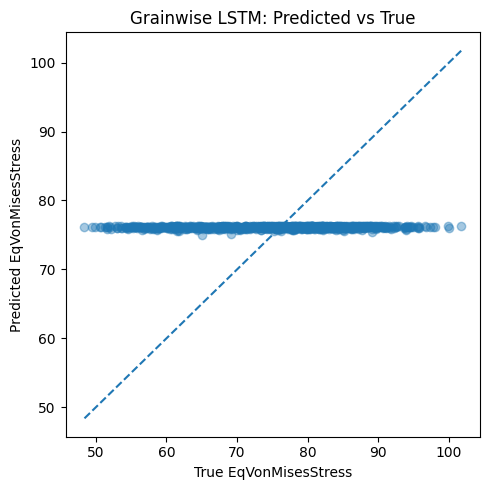

Saved figure to: C:\Users\laksh\microstructure-project\results\figures\grain_lstm_pred_vs_true.png


In [7]:
fig_dir = os.path.join(PROJECT_ROOT, "results", "figures")
os.makedirs(fig_dir, exist_ok=True)
fig_path = os.path.join(fig_dir, "grain_lstm_pred_vs_true.png")

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         linestyle="--")
plt.xlabel("True EqVonMisesStress")
plt.ylabel("Predicted EqVonMisesStress")
plt.title("Grainwise LSTM: Predicted vs True")
plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()

print("Saved figure to:", fig_path)
